<a href="https://colab.research.google.com/github/atf95/MSAAI500-spring23-team4/blob/main/choralesData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyparsing import OneOrMore, nestedExpr
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
#read in the data from the LISP formatted text file
#as a list of text strings formatted as [line1, line2,...]
with open('chorales.txt') as f:
    alldata = f.readlines()
#removes blank new lines between data entries
while('\n' in alldata):
  alldata.remove('\n')

In [5]:
#extract data from a single chorale as df

def oneChorDF(data,chorNum):
  #parses parentheses as list brackets
  oneChor = data[chorNum]
  oneChor = OneOrMore(nestedExpr()).parseString(oneChor)
  oneChor = oneChor[0].asList()[1:] #removes encasing brackets and chorale number
  
  #convert to pandas dataframe
  headers = ['st','pitch','dur','keysig','timesig','fermata']
  values = []
  count = 0
  for i in oneChor:
    values.append([])
    for j in i:
      values[count].append(j[1])
    count += 1
  
  return pd.DataFrame(values, columns = headers, dtype = float)
#print example of the first chord
one = oneChorDF(alldata, 0)
one.head()

,st,pitch,dur,keysig,timesig,fermata
0,8.0,67.0,4.0,1.0,12.0,0.0
1,12.0,67.0,8.0,1.0,12.0,0.0
2,20.0,74.0,4.0,1.0,12.0,0.0
3,24.0,71.0,6.0,1.0,12.0,0.0
4,30.0,69.0,2.0,1.0,12.0,0.0


In [6]:
#extract data from all chorales as a single df
def allChorDF(data):
  alldf = pd.DataFrame()
  for i in range(len(data)):
   alldf = alldf.append(oneChorDF(data, i))
   #print progress
   if (i+1)%20 == 0:
     print(i+1, 'chorales appended')
  return alldf

allDF = allChorDF(alldata)

20 chorales appended
40 chorales appended
60 chorales appended
80 chorales appended
100 chorales appended


In [7]:
#treating the data so that pitches of the same octave are grouped
#midi numbers represent semitones, octaves are 12 apart (eg. c4= 60, c5= 72)
#after transform C=0, D=2, E=4, F=5, G=7, A=9, B=11
def byOctave(df):
  df['note'] = df['pitch']%12

byOctave(allDF)
allDF.head()

,st,pitch,dur,keysig,timesig,fermata,note
0,8.0,67.0,4.0,1.0,12.0,0.0,7.0
1,12.0,67.0,8.0,1.0,12.0,0.0,7.0
2,20.0,74.0,4.0,1.0,12.0,0.0,2.0
3,24.0,71.0,6.0,1.0,12.0,0.0,11.0
4,30.0,69.0,2.0,1.0,12.0,0.0,9.0


70.40954613253783


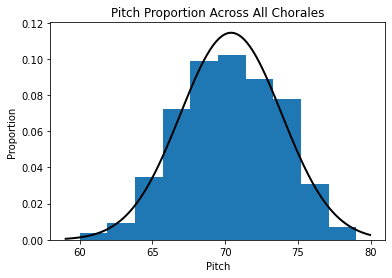

In [74]:
#histogram of proportion of pitches in all chorales
plt.hist(allDF['pitch'], density = True, bins = 10)
plt.title('Pitch Proportion Across All Chorales')
plt.xlabel('Pitch'); plt.ylabel('Proportion')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, allDF['pitch'].mean(), allDF['pitch'].std())
print(allDF['pitch'].mean())  
plt.plot(x, p, 'k', linewidth=2)
plt.show()

20 chorales appended
40 chorales appended
60 chorales appended
80 chorales appended
100 chorales appended


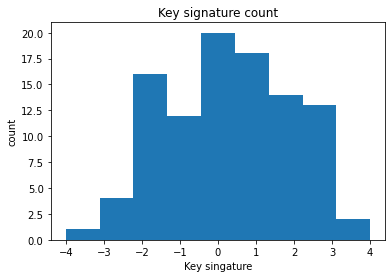

In [10]:
#DF of note counts and keysig of each chorale
noteCounts = pd.DataFrame()

for i in range(len(alldata)):

  chor = oneChorDF(alldata, i)
  byOctave(chor)
   
  counts = chor['note'].value_counts().to_frame().T.rename(index = {'note': i+1})
  counts['keysig'] = chor['keysig'][0]
  noteCounts = noteCounts.append(counts)
  if (i+1)%20 == 0:
     print(i+1, 'chorales appended')
noteCounts = noteCounts.fillna(0.0)
noteCounts.head()
#histogram of key signature counts
plt.hist(noteCounts['keysig'], bins = 9)
plt.title('Key signature count')
plt.xlabel('Key singature'); plt.ylabel('count')
plt.show()

In [63]:
#time scaled: add additional counts for longer notes, by multiplying by the duration feature
noteDurs = pd.DataFrame()

for i in range(len(alldata)):
  by16s = pd.DataFrame()
  chor = oneChorDF(alldata, i)
  byOctave(chor)
  for j in range(len(chor)):
    
    for k in range(int(chor.iloc[j,2])):
      by16s = by16s.append(chor.iloc[[j]])
  counts = by16s['note'].value_counts().to_frame().T.rename(index = {'note': i+1})
  counts['keysig'] = chor['keysig'][0]
  noteDurs = noteDurs.append(counts)
  if (i+1)%20 == 0:
     print(i+1, 'chorales appended')
noteDurs = noteDurs.fillna(0.0)
noteDurs.head()


20 chorales appended
40 chorales appended
60 chorales appended
80 chorales appended
100 chorales appended


,11.0,7.0,9.0,2.0,0.0,keysig,1.0,4.0,6.0,8.0,10.0,3.0,5.0
1,74.0,56.0,50.0,46.0,26.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,58.0,4.0,44.0,20.0,0.0,3.0,36.0,26.0,10.0,6.0,4.0,0.0,0.0
3,40.0,12.0,36.0,15.0,31.0,1.0,0.0,16.0,6.0,4.0,0.0,0.0,0.0
4,52.0,0.0,14.0,4.0,0.0,4.0,24.0,16.0,10.0,22.0,4.0,14.0,0.0
5,60.0,30.0,54.0,44.0,48.0,1.0,4.0,28.0,0.0,0.0,0.0,0.0,4.0


In [108]:
#normalize by dividing note duration by total duration of each chorale
#for the proportion of each note duration
sums = noteDurs.sum(axis = 1)
durProps = noteDurs.div(sums, axis=0)
durProps[['keysig']] = noteDurs[['keysig']]
durProps = durProps.rename(columns = {0.0: 'C',1.0: 'Cs',2.0: 'D',
                                      3.0: 'Ds',4.0: 'E',5.0: 'F',
                                      6.0: 'Fs',7.0: 'G',8.0: 'Gs',
                                      9.0: 'A',10.0: 'As',11.0: 'B'})
durProps.head()

,B,G,A,D,C,keysig,Cs,E,Fs,Gs,As,Ds,F
1,0.292490,0.221344,0.197628,0.181818,0.102767,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.274882,0.018957,0.208531,0.094787,0.000000,3.0,0.170616,0.123223,0.047393,0.028436,0.018957,0.000000,0.000000
3,0.248447,0.074534,0.223602,0.093168,0.192547,1.0,0.000000,0.099379,0.037267,0.024845,0.000000,0.000000,0.000000
4,0.317073,0.000000,0.085366,0.024390,0.000000,4.0,0.146341,0.097561,0.060976,0.134146,0.024390,0.085366,0.000000
5,0.219780,0.109890,0.197802,0.161172,0.175824,1.0,0.014652,0.102564,0.000000,0.000000,0.000000,0.000000,0.014652


In [326]:
#removing samples of key -4, -3, 4 due to low counts
for i in [-4.0, -3.0, 4.0]:
  durProps = durProps[durProps.keysig != i]

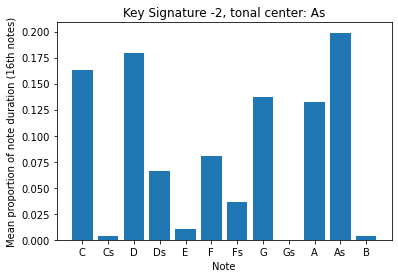

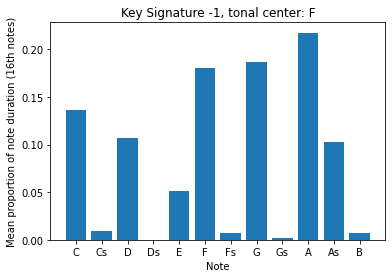

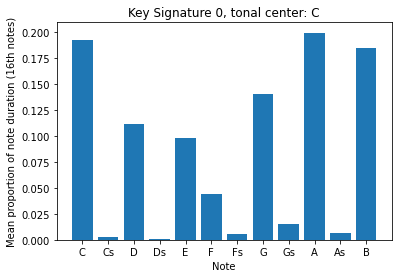

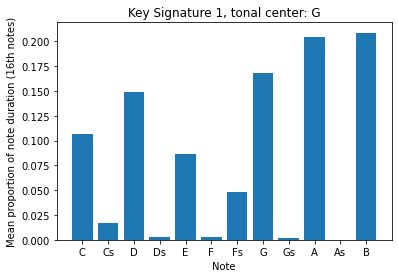

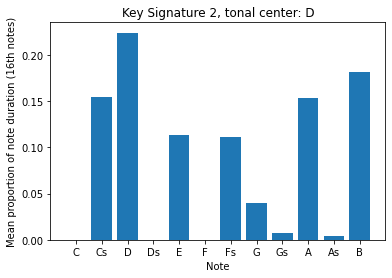

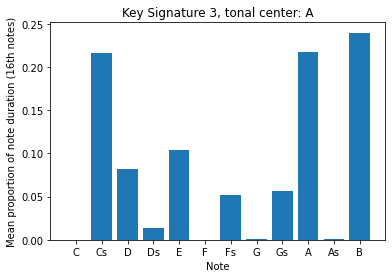

In [629]:
#for visualization, bar plot of the mean duration proportion for each key signature
for i in np.arange(-2,4,1):
  onekey = durProps[durProps['keysig'] == i]
  onekey = onekey[['C','Cs','D',
                   'Ds','E','F',
                   'Fs','G','Gs',
                   'A','As','B']]
  onekey = onekey.sum(axis = 0).to_frame().T/(len(onekey))
  cols = ['C','Cs','D',
          'Ds','E','F',
          'Fs','G','Gs',
          'A','As','B']
  plt.bar(cols,onekey.iloc[0])
  plt.title('Key Signature ' + str(i) + ', tonal center: ' + cols[(7*i)%12])
  plt.xlabel('Note'); plt.ylabel('Mean proportion of note duration (16th notes)')
  plt.show()

In [581]:
#encode keysignature column for individual binomial GLM fits
encoded = pd.get_dummies(durProps, columns=['keysig'])
encoded = encoded.rename(columns = {'keysig_-4.0': 'keyn4',
                                    'keysig_-3.0': 'keyn3',
                                    'keysig_-2.0': 'keyn2',
                                    'keysig_-1.0': 'keyn1',
                                    'keysig_0.0': 'key0',
                                    'keysig_1.0': 'key1',
                                    'keysig_2.0': 'key2',
                                    'keysig_3.0': 'key3',
                                    'keysig_4.0': 'key4'})
encoded.head()

,B,G,A,D,C,Cs,E,Fs,Gs,As,Ds,F,keyn2,keyn1,key0,key1,key2,key3
1,0.292490,0.221344,0.197628,0.181818,0.102767,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0,0,0,1,0,0
2,0.274882,0.018957,0.208531,0.094787,0.000000,0.170616,0.123223,0.047393,0.028436,0.018957,0.0,0.000000,0,0,0,0,0,1
3,0.248447,0.074534,0.223602,0.093168,0.192547,0.000000,0.099379,0.037267,0.024845,0.000000,0.0,0.000000,0,0,0,1,0,0
5,0.219780,0.109890,0.197802,0.161172,0.175824,0.014652,0.102564,0.000000,0.000000,0.000000,0.0,0.014652,0,0,0,1,0,0
6,0.000000,0.130081,0.260163,0.130081,0.162602,0.000000,0.065041,0.000000,0.000000,0.097561,0.0,0.162602,0,1,0,0,0,0


<AxesSubplot:>

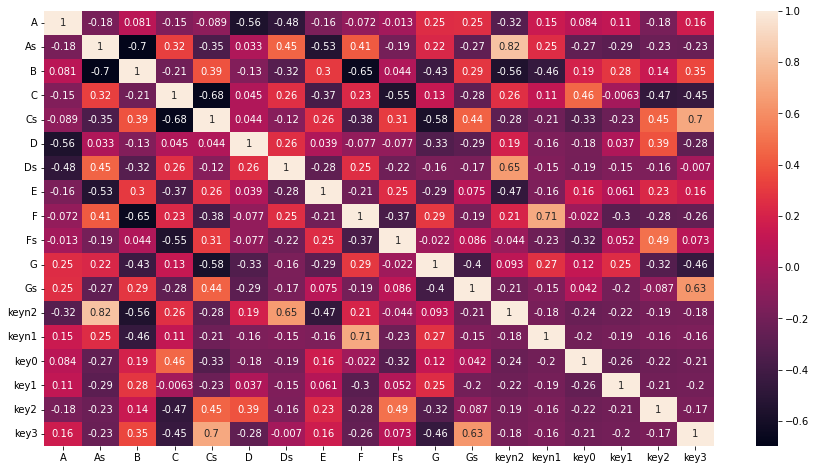

In [582]:
#visualization of the note and key signature correlations
import seaborn as sns
test = encoded[['A','As','B','C','Cs','D','Ds','E','F','Fs','G','Gs','keyn2','keyn1','key0','key1','key2','key3']]
plt.figure(figsize=(15,8))
sns.heatmap(test.corr(), annot=True)

In [626]:
#75 25 test split
from sklearn.model_selection import train_test_split
X = encoded[['A','As','B','C','Cs','D','Ds','E','F','Fs','G','Gs']]
Y = encoded[['keyn2','keyn1','key0','key1','key2','key3']]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.25)#, random_state=100)
Ytrain.shape

(69, 6)

In [630]:
#Binomial GLM fits for each key signature
testdata = pd.concat([Xtrain, Ytrain], axis=1)

fitn2 = smf.glm('keyn2 ~ A + C + Cs + D + Ds + Gs', family = sm.families.Binomial(), data=testdata).fit()
fitn1 = smf.glm('keyn1 ~ As + B + Cs + F + Fs + G', family = sm.families.Binomial(), data=testdata).fit()
fit0 = smf.glm('key0 ~ As + B + C + Cs + Ds + Fs', family = sm.families.Binomial(), data=testdata).fit()
fit1 = smf.glm('key1 ~ As + B + Cs + F + G + Gs', family = sm.families.Binomial(), data=testdata).fit()
fit2 = smf.glm('key2 ~ As + Cs + D + E + F + G', family = sm.families.Binomial(), data=testdata).fit()
fit3 = smf.glm('key3 ~ As + B + D + F + Gs', family = sm.families.Binomial(), data=testdata).fit()
#Response variables removed based and correlation in order to avoid "perfect separation" error
fit0.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   key0   No. Observations:                   69
Model:                            GLM   Df Residuals:                       62
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12.163
Date:                Tue, 28 Feb 2023   Deviance:                       24.325
Time:                        04:24:53   Pearson chi2:                     48.2
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0197      1.566      0.651      0.515      -2.049       4.088
As           -46.9224     20.351     -2.306      0.021     -86.809      -7.035
B             -8.2491      6.413     -1.286      0.198     -20.818       4.319
C             11.6497      8.345      1.396      0.163      -4.707      28.006
Cs         -1724.0045   1.27e+06     -0.001      0.999   -2.49e+06    2.48e+06
Ds            -7.7206     42.454     -0.182      0.856     -90.929      75.487
Fs           -37.1411     28.327     -1.311      0.190     -92.660      18.378
==============================================================================
"""

In [628]:
#get P(keysignature) for each row in the test set
predn2 = fitn2.predict(Xtest)
predn1 = fitn1.predict(Xtest)
pred0 = fit0.predict(Xtest)
pred1 = fit1.predict(Xtest)
pred2 = fit2.predict(Xtest)
pred3 = fit3.predict(Xtest)
#get index of the highest probable key sig
#take percentage of predictions that match Ytest
predFinal = pd.concat([predn2,predn1,pred0,pred1,pred2], axis=1).idxmax(axis = 1) - 2
Ytest = Ytest.rename(columns = {'keyn2': -2,
                                'keyn1': -1,
                                'key0': 0,
                                'key1': 1,
                                'key2': 2,
                                'key3': 3}).idxmax(axis = 1)
a = pd.concat([predFinal,Ytest], axis = 1)
len(a[a[0] == a[1]])/len(a)

0.6666666666666666

In [640]:
#train test data split
from sklearn.model_selection import train_test_split
X = durProps[['A','As','B','C','Cs','D','Ds','E','F','Fs','G','Gs']]
Y = durProps[['keysig']].astype(str)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.25)#, random_state=100)


In [643]:
#decision tree model
from sklearn import tree
import sklearn.metrics as met
clf = tree.DecisionTreeClassifier(criterion = 'gini')
clf = clf.fit(Xtrain, Ytrain)

pred = clf.predict(Xtest)
print(met.classification_report(Ytest,pred))

              precision    recall  f1-score   support

        -1.0       1.00      0.67      0.80         3
        -2.0       1.00      1.00      1.00         3
         0.0       0.50      0.80      0.62         5
         1.0       0.60      0.43      0.50         7
         2.0       1.00      1.00      1.00         3
         3.0       1.00      1.00      1.00         3

    accuracy                           0.75        24
   macro avg       0.85      0.82      0.82        24
weighted avg       0.78      0.75      0.75        24



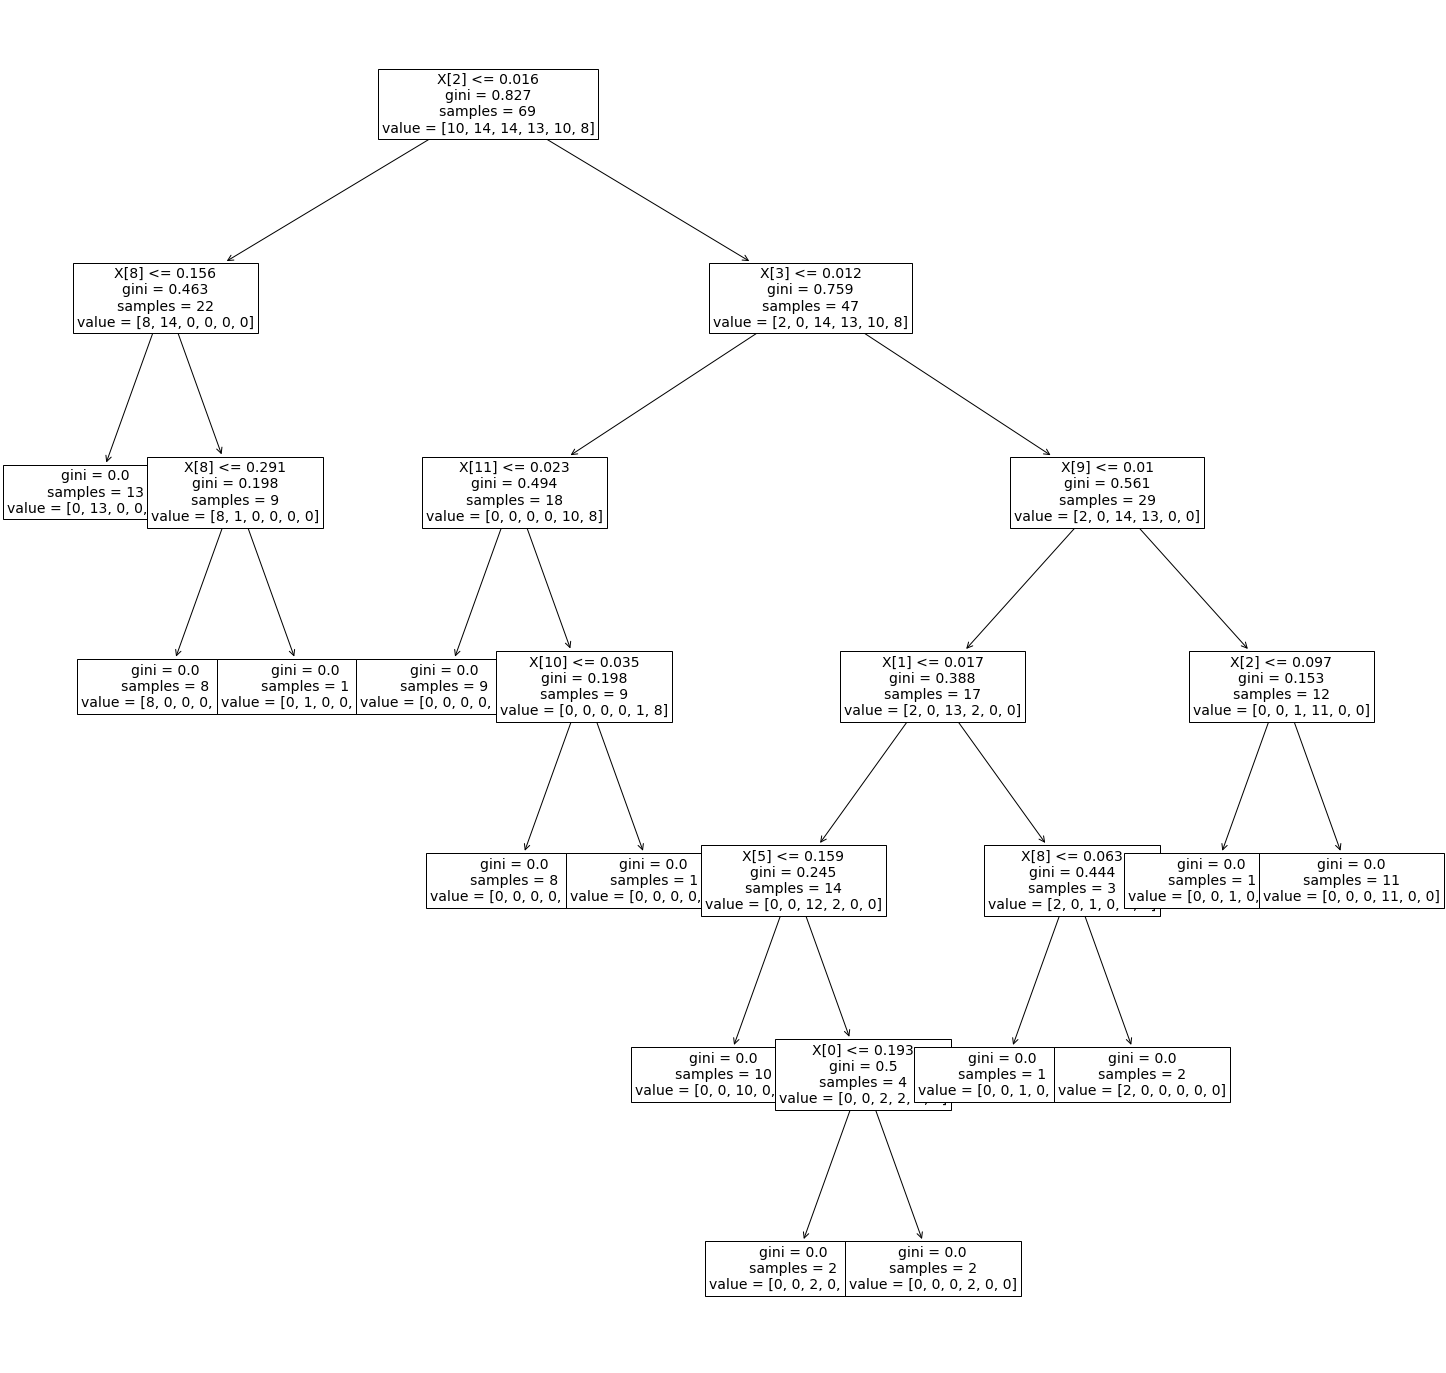

In [634]:
#visualization of decision tree
plt.figure(figsize=(25,25))
a = tree.plot_tree(clf, fontsize = 14)